In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn as nn

import os
import argparse

import h5py
from sklearn.cluster import KMeans
from matplotlib import cm
from PIL import Image
import openslide

# Attention-based Evaluation of Self-Supervised Embeddings

We have been attempting to build a computational model of Braak score with one goal in mind: Given a large whole slide image, can we decompose it into tiles and predict Braak score using tile-level features. This approach comes with many advantages, namely the unsupervisability of tile-feature learning. Braak is a metric commonly used by neurohistopathologists to grade thelevel of neurodegenration in the brain. It is based on the development of neurofibrillary tangles throughout much of the brain, and is separated into scores from 0 to 6. Scores 0 through 4 rely solely on hippocampal tau buildup, whereas 5 and 6 incorporate neocortical tau. Therefore, we have decided to collapse 4, 5, and 6 into one consistent score, as weonly possess hippocampal images.

Previously, we trained a ResNet-50 encoder using Bootstrap your own Latent (BYOL). BYOL is a self-supervised training paradigm which relies on an online and target network. The online network is trained with images, and the target is a constant moving average of the online.The goal is simple: maximize the similarity between the outputs of the two networks. The BYOL trained encoder is then used to extract features from a given image. In our case, a slide is then composed of all of its tile's feature vectors. In this project, we have aimed to refine our pooling stage, which takes the large numberof tile vectors and collapses them into a single, representative feature vector for the entire slide.

The theory behind using attention is simple: not every tile in a slide is useful for scoring Braak. An attention mechanism will selectively weight different tiles in a slide to increase or decrease their impact on the classifiers decision. In a sense, linear regression is performing 'attention' over the attributes of a data set to determine which ones most heavily influence the outcome. 

Our implementation of attention occurs at the pooling stage, where all of the tile embeddings in a slide (ranging in number from 10,000 to 25,000) are combined into a single feature vector. Until recently, the most common technique to do this was simply average pooling each feature over the entire slide. However, attention will weight each tile individually before pooling, allowing for selection of the most impactful tiles. Our method follows these steps:

1. Reduce the dimensionality of the feature space from 2048 (x) to 384 (h) through a series of fully connected layers.
2. Compute 2 separate attention mechanisms over the reduced feature space h (attention_a and attention_b)
    - a and b are essentially the same, apart from their activation functions. It has been fairly common to use multiple different attention heads to avoid any deleterious effects of one vs the other
3. Multiply the two attention mechanisms together before passing them through a final fully connected layer which reduces the attention to a vector of size (1, # tiles). This is the final attention vector ready to weight the tiles.
4. Take the softmax of the attention vector to normalize its weighting. 
5. Multiply the transpose of the attention vector with the tile feature matrix to receive a 1xh representative pooling of the entire slide. 
6. Train an ordinal regression model with this pooled feature vector.

We are using CORAL regression in our experiments due to the nature of Braak scores. Given than Braak is an ordinal, discrete scale, we thought it best to not use a typical classification method like logistic regression, as it will not fully capture the ordinality of our data. Any models without attention operate similarly - the feature reducing linear layers are preserved, but an avgpool is included instead of an attention pooling method. The model, with comments is included below.

In [ ]:
# Attention + ordinal regression model.
class BRAAK_attention(nn.Module):
    def __init__(self, gate=True, L=2048, size="big", dropout=False, n_classes=5):
        super(BRAAK_attention, self).__init__()
        
        # setup of the dimensions of the model        
        self.size_dict = {"small": [L, 512, 256], "big": [L, 512, 384]}
        size = self.size_dict[size]
        
        # setup of the linear feature-reduction layer
        fc = [nn.Linear(size[0], size[1]), nn.ReLU()]
        if dropout:
            fc.append(nn.Dropout(0.25))
        self.fc = nn.Sequential(*fc)
        
        # attention head setup
        self.attention_a = [nn.Linear(size[1], size[2]), nn.Tanh()]            
        self.attention_b = [nn.Linear(size[1], size[2]), nn.Sigmoid()]            
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))
        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        self.attention_c = nn.Linear(size[2], 1)
        
        # final classification layer
        self.classifiers = CoralLayer(size_in=size[1], num_classes=n_classes)
        self.n_classes = n_classes

    def forward(self, x, label=None, instance_eval=False, return_features=False, attention_only=False):
        # reduce the dimensionality of the feature space with a fully connected layer
        h = self.fc(x)
        # compute the attention heads
        a = self.attention_a(h)
        b = self.attention_b(h)
        A = a.mul(b)
        A = self.attention_c(A)
        
        # transpose the attention vector and softmax it
        A = torch.transpose(A, 1, 0)  # KxN
        if attention_only:
            return A
        A_raw = A
        A = F.softmax(A, dim=1)  # softmax over N
        
        # multiply the attention with the data and pas it along the the classifier
        M = torch.mm(A, h) 
        logits = self.classifiers(M)
        
        # converting between probabilities and labels. 
        Y_prob = torch.sigmoid(logits)
        Y_hat  = proba_to_label(Y_prob)

        return logits, Y_prob, Y_hat, A_raw

Given the size of the full-slide embeddings and data-privacy measures, we were unable to run training from a notebook on google colab or otherwise. The model was trained on Mt. Sinai's in-house cluster computer for 1000 epochs at a batch size of 25. The training loop along with the modules used for it can be found in this repo under 'training_modules'. 

### Results

We chose to evaluate our model based on root-mean-squared-error. Given that the distance between the predicted and ground-truth Braak scores is meaningful, we did not think it appropriate to use accuracy or a similar measure. 

We evaluated several models in our experiments:
1. BYOL-generated embeddings with attention
2. Imagenet-pretrained embeddings with attention
3. BYOL-generated embeddings without attention
4. Imagenet-pretrained embeddings without attention

These experiments should provide us a good sense of whether attention is beneficial to the classification of our embeddings, and whether it is beneficial to use our trained BYOL to embed the tiles. 

In [3]:
byol_attention_data = torch.load("./logs_and_models/byol_attention/training_data.pth", map_location="cpu")
pt_attention_data = torch.load("./logs_and_models/imagenet_attention/training_data.pth", map_location="cpu")
byol_noattention_data = torch.load("./logs_and_models/byol_no_attention/training_data.pth", map_location="cpu")
pt_noattention_data = torch.load("./logs_and_models/imagenet_no_attention/training_data.pth", map_location="cpu")

#### Basic training data

To confirm the training of our model, we simply plot the training loss and RMSE of both our train and test set throughout training epochs.

Text(0, 0.5, 'RMSE')

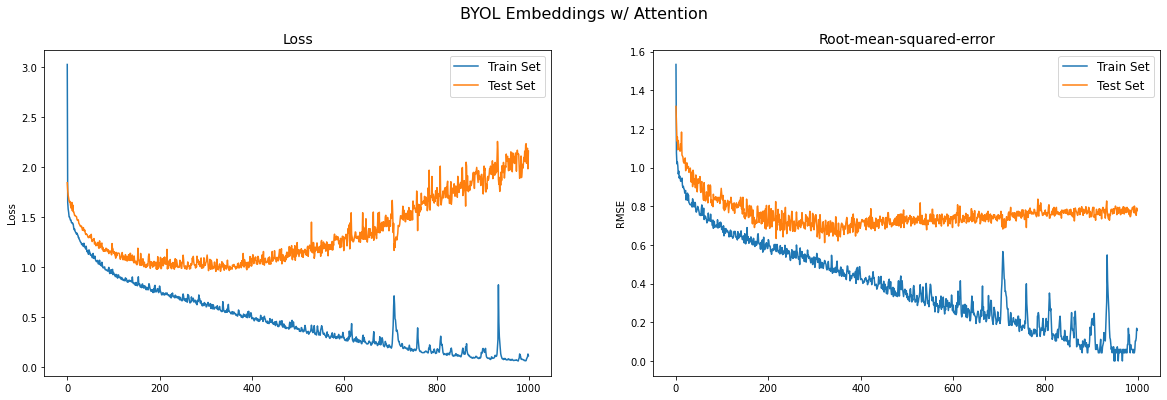

In [4]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
fig.suptitle("BYOL Embeddings w/ Attention", fontsize=16)
ax[0].plot(byol_attention_data["train_loss"], label="Train Set")
ax[0].plot(byol_attention_data["val_loss"], label="Test Set")
ax[0].legend(fontsize=12)
ax[0].set_title("Loss", fontsize=14)
ax[0].set_ylabel("Loss")
ax[1].plot(byol_attention_data["train_rmse"], label="Train Set")
ax[1].plot(byol_attention_data["val_rmse"], label="Test Set")
ax[1].legend(fontsize=12)
ax[1].set_title("Root-mean-squared-error", fontsize=14)
ax[1].set_ylabel("RMSE")

One quite interesting facet of training is that while the RMSE continues to fall for the test set, its loss does not. Obviously the loss function of not the same as RMSE, but it seems counterintuitive that the loss increases along with the model's performance. 

Text(0, 0.5, 'RMSE')

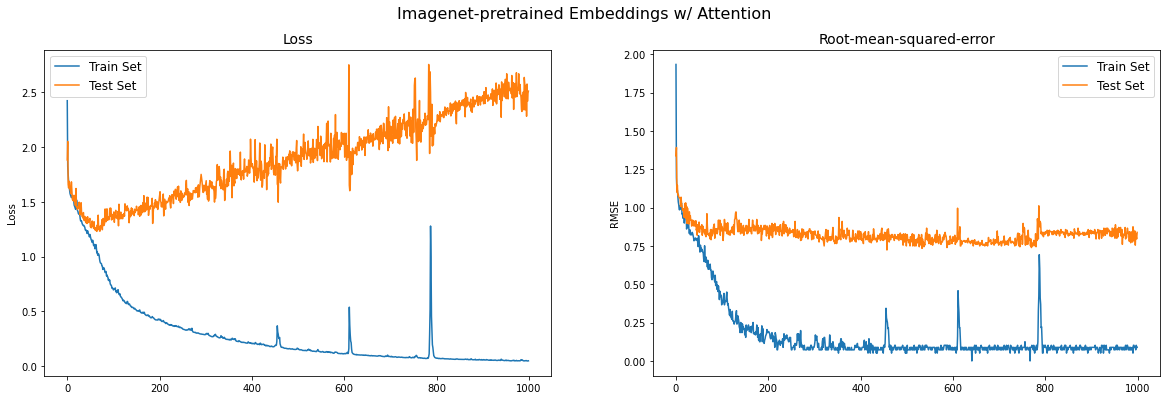

In [5]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
fig.suptitle("Imagenet-pretrained Embeddings w/ Attention", fontsize=16)
ax[0].plot(pt_attention_data["train_loss"], label="Train Set")
ax[0].plot(pt_attention_data["val_loss"], label="Test Set")
ax[0].legend(fontsize=12)
ax[0].set_title("Loss", fontsize=14)
ax[0].set_ylabel("Loss")
ax[1].plot(pt_attention_data["train_rmse"], label="Train Set")
ax[1].plot(pt_attention_data["val_rmse"], label="Test Set")
ax[1].legend(fontsize=12)
ax[1].set_title("Root-mean-squared-error", fontsize=14)
ax[1].set_ylabel("RMSE")

Text(0, 0.5, 'RMSE')

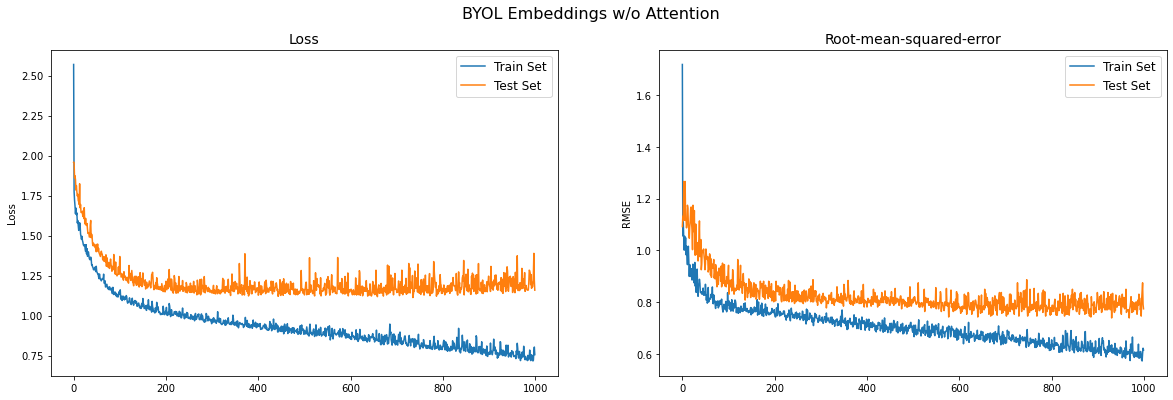

In [8]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
fig.suptitle("BYOL Embeddings w/o Attention", fontsize=16)
ax[0].plot(byol_noattention_data["train_loss"], label="Train Set")
ax[0].plot(byol_noattention_data["val_loss"], label="Test Set")
ax[0].legend(fontsize=12)
ax[0].set_title("Loss", fontsize=14)
ax[0].set_ylabel("Loss")
ax[1].plot(byol_noattention_data["train_rmse"], label="Train Set")
ax[1].plot(byol_noattention_data["val_rmse"], label="Test Set")
ax[1].legend(fontsize=12)
ax[1].set_title("Root-mean-squared-error", fontsize=14)
ax[1].set_ylabel("RMSE")

Text(0, 0.5, 'RMSE')

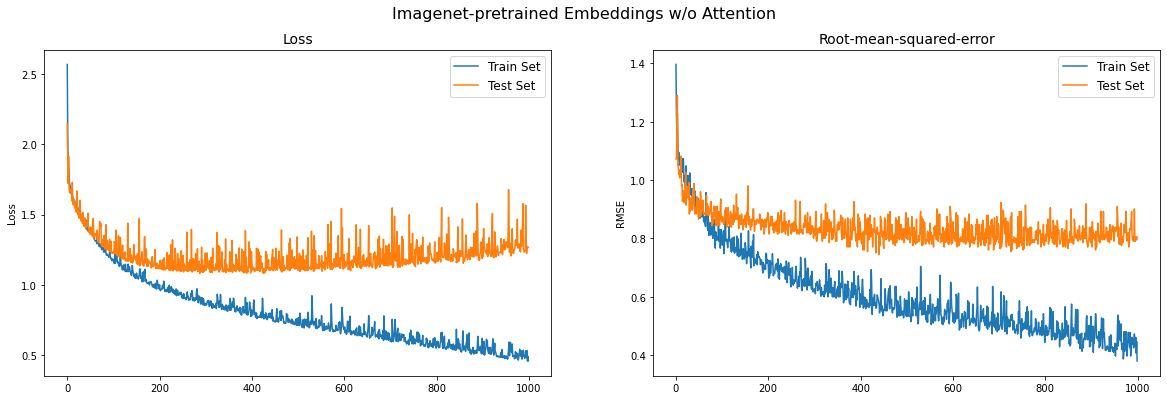

In [9]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
fig.suptitle("Imagenet-pretrained Embeddings w/o Attention", fontsize=16)
ax[0].plot(pt_noattention_data["train_loss"], label="Train Set")
ax[0].plot(pt_noattention_data["val_loss"], label="Test Set")
ax[0].legend(fontsize=12)
ax[0].set_title("Loss", fontsize=14)
ax[0].set_ylabel("Loss")
ax[1].plot(pt_noattention_data["train_rmse"], label="Train Set")
ax[1].plot(pt_noattention_data["val_rmse"], label="Test Set")
ax[1].legend(fontsize=12)
ax[1].set_title("Root-mean-squared-error", fontsize=14)
ax[1].set_ylabel("RMSE")

Interestingly, the models without attention avoid the appearance of overfitting shown by the attention models. However, I am not strongly convinced of these results, as none of the models really achieved full convergence - in other words, their loss is still decreasing. Some more training and/or training with a higher learning rate is probably needed.

#### Comparison

In previous experiments, we used an average pooling strategy paired with several different regression methods. The highest performing method was ordinal ridge regression on average pooled BYOL embeddings, scoring an RMSE of **0.81**.

Text(0, 0.5, 'RMSE')

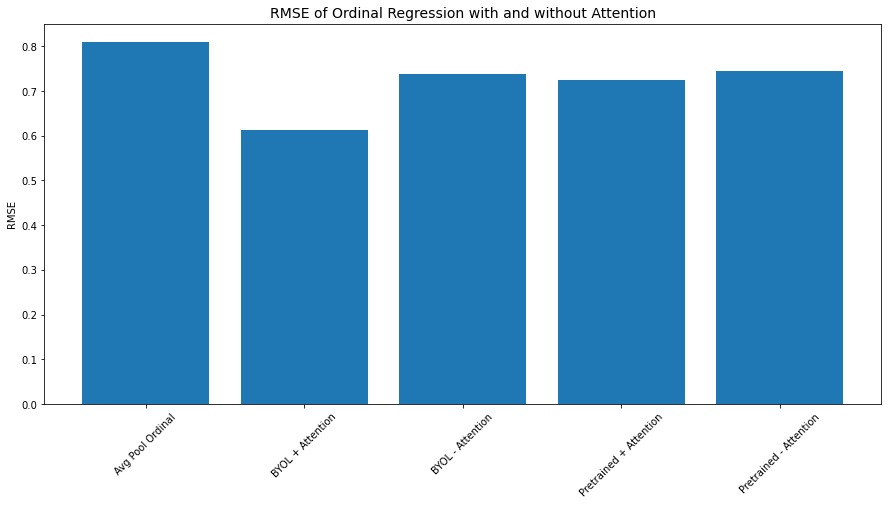

In [10]:
best_byol_att = min(byol_attention_data["val_rmse"])
best_im_att = min(pt_attention_data["val_rmse"])
best_byol_noatt = min(byol_noattention_data['val_rmse'])
best_im_noatt = min(pt_noattention_data['val_rmse'])
best_prev = 0.81

labels = ['Avg Pool Ordinal', 'BYOL + Attention', 'BYOL - Attention', 'Pretrained + Attention', 'Pretrained - Attention']
data = [best_prev, best_byol_att, best_byol_noatt, best_im_att, best_im_noatt]

fig = plt.figure();
fig.set_size_inches(15,7)
plt.bar(labels, data);
plt.xticks(rotation=45, horizontalalignment='center');
plt.title('RMSE of Ordinal Regression with and without Attention', fontsize=14)
plt.ylabel('RMSE')

#### Conclusion

Our attention models performs about on par with our previous best effort. Unfortunately, the no attention model outperforms an attention-based pooling in both instances. However, I am not conviced that the models have truly reached their minimums, as the loss is still steadily declining, even at epoch 1000. This call for further training of the models.

#### Attention Heatmaps

One added feature of attention is the ability to observe the focus of attention of the images. This actually permits some further analysis of the model, as it can be used to highlight the important brain regionsfor classification.

Text(0.5, 0.98, 'Heavy Tau Burden Heatmap')

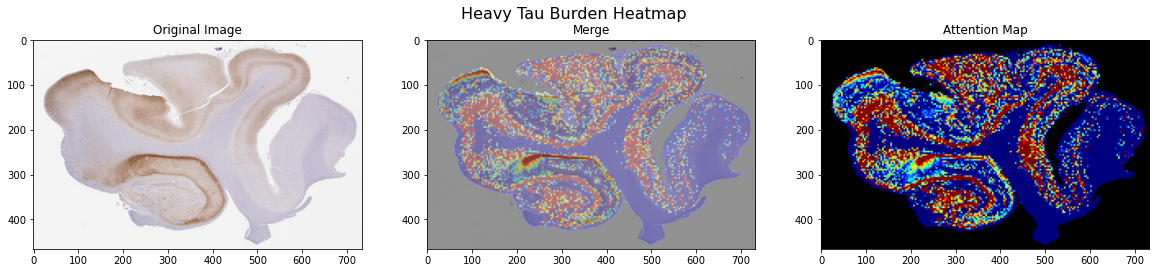

In [15]:
import skimage.io as io
from skimage.transform import resize

orig_45505 = io.imread('./orig_at8_45505.png')
att_45505 = io.imread('./45505_attention_map.png')
att_45505 = resize(att_45505, orig_45505.shape, anti_aliasing=True)


fig, ax = plt.subplots(1,3)
fig.set_size_inches(20, 4)

ax[0].imshow(orig_45505)
ax[0].set_title('Original Image')
ax[1].imshow(orig_45505)
ax[1].imshow(att_45505, alpha=0.4)
ax[1].set_title('Merge')
ax[2].imshow(att_45505)
ax[2].set_title('Attention Map')
fig.suptitle('Heavy Tau Burden Heatmap', fontsize=16)

Text(0.5, 0.98, 'No Tau Burden Heatmap')

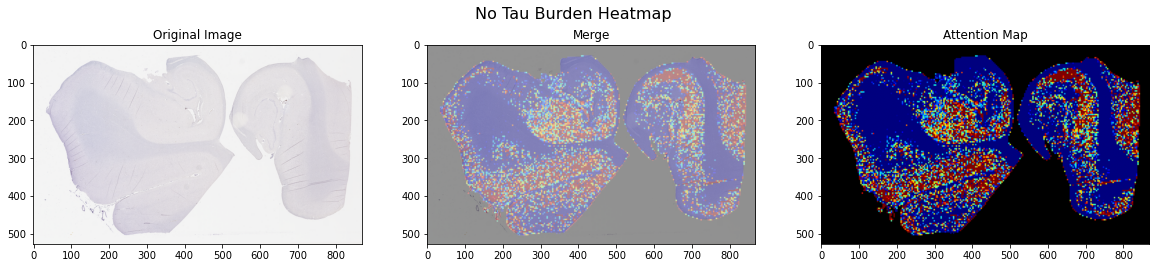

In [16]:
orig_45883 = io.imread('./orig_at8_45883.png')
att_45883 = io.imread('./45883_attention_map.png')
att_45883 = resize(att_45883, orig_45883.shape, anti_aliasing=True)


fig, ax = plt.subplots(1,3)
fig.set_size_inches(20, 4)

ax[0].imshow(orig_45883)
ax[0].set_title('Original Image')
ax[1].imshow(orig_45883)
ax[1].imshow(att_45883, alpha=0.4)
ax[1].set_title('Merge')
ax[2].imshow(att_45883)
ax[2].set_title('Attention Map')
fig.suptitle('No Tau Burden Heatmap', fontsize=16)

Interestingly, the attention seems to functioning extremely well in terms of selecting important regions. The white matter throughout the center of the image is entirely unemphasized, which is consistent with the physiology of tau. Additionally, the dentate and other dense pyramidal cell layers are highly emphasized. Again, this is highly consistent with the supporting biology. 

This is compelling evidence to continue our work on an attention mechanism, given that the attention is in fact highlighting the important regions of the brain for tau burden. Additionallym it supports our conclusions from the KMeans work, showing that our embeddings can in fact be used to distinguish anatomically.

# Kmeans analysis of BYOL derived latent space
In this next section, kmeans clustering will be performed on feature vectors produced by BYOL. The dataset is AT8 immunohistochemically stained whole slide images of human hippocampus that have been digitized. The kmeans clustering will show how richely the features represent the anatomy and pathology of the dataset. 

The below code is a Pytorch dataloader which yields a tensor of a 256x256 patch of the provided slide image at the index of coordinates. The function uses an h5file which is the ouput of a segmentation function provided by CLAM (https://github.com/mahmoodlab/CLAM/blob/master/create_patches.py) which is an array of top-left coordinates of 256x256 patches that contain tissue. This ensures that we do not get any background in our analysis.  

In [ ]:
class FeatureCreationDataset(torch.utils.data.Dataset):
    """ This dataset assumes that only one slide will be instantiated with.
        Additionally, it assumes no transforms.
    """
    def __init__(self, slide='', h5file='', tilesize = 256):
        self.tilesize = tilesize
        
        self.slidepath = slide
        self.wsi = openslide.OpenSlide(slide)
        
        self.h5path = h5file
        f = h5py.File(h5file,'r')
        self.coords = np.asarray(f['coords'])

        self.transform = transforms.ToTensor()

    def __len__(self):
        return(self.coords.shape[0])
    
    def __getitem__(self, idx):
        coord = self.coords[idx,:]
        tile = self.wsi.read_region((coord[0], coord[1]),0,(self.tilesize, self.tilesize)).convert('RGB')

        img = self.transform(tile)
            
        return img

This function will create the feature vectors based on the supplied slide images using a supplied pretrained BYOL model. It can also create feature vectors using Resnet50 pretrained on an Imagenet classification task (weights provided by Pytorch).

In [ ]:
def make_byol_features_to_np(slide='', h5file='', checkpoint="/sc/arion/projects/tauomics/BYOL-tau-scoring/BYOL/models/trained_resnet6.pth", imagenet_pretrained=False, tilesize = 256, batch_size = 400):
    """ Make features from images by passing them through a resnet encoder"""
    
    tile_dataset = FeatureCreationDataset(slide=slide, h5file=h5file, tilesize = 256)
    loader = torch.utils.data.DataLoader(tile_dataset,
                                              batch_size=batch_size, 
                                              num_workers=5, 
                                              shuffle=False,
                                              drop_last=False)

    device=torch.device('cuda')
    
    # encoder setup
    if imagenet_pretrained:
        resnet = torchvision.models.resnet50(pretrained=True)
        resnet.fc = nn.Identity()
    else:
        resnet = torchvision.models.resnet50(pretrained=False)  
        resnet.fc = nn.Identity()
        resnet.load_state_dict(torch.load(checkpoint))


    resnet = nn.DataParallel(resnet)
    resnet = resnet.to(device)
    print("Model created", flush=True)

    feats = []
    labels = []
    resnet = resnet.eval()
    for batch, (img) in enumerate(loader):
        img = img.to(device)
        
        with torch.no_grad():
            h_i = resnet(img)

        
        feats.append(h_i)
    
    feats = torch.cat(feats, dim=0)
    feats = feats.squeeze()
    feats = feats.cpu().numpy()
    
    print("Finished embedding. Feature array shape:", feats.shape)    
    
    return feats

This function takes feature vectors and will run k-means clustering with a given k value and will return the cluster labels for each feature vector. 

In [ ]:
def run_kmeans(feats, k=5, seed=51):
    sample_kmeans = KMeans(n_clusters=k, random_state=seed)
    labels = sample_kmeans.fit_predict(feats)
    return labels

This function creates maps based on the given cluster assignments of each patch. 


In [ ]:
def make_maps(labels, h5file, w, h, outfile, downsample = 20, tiledim = 256):
    
    f = h5py.File(h5file,'r')
    coords = np.asarray(f['coords'])


    mask = np.zeros((h,w,3))

    values = [ np.array(cm.Paired_r(i)[:3]) * 255 for i in set(labels) ]
    cmap = dict(zip(set(labels),values))

    for l,(x,y) in zip(labels,coords):
        mask[y:y+tiledim,x:x+tiledim,:] = cmap[l]

    image = Image.fromarray(mask.astype(np.uint8))
    size = image.size
    image = image.resize((int(size[0]/downsample),int(size[1]/downsample)))
    image.save(outfile)

    return

Here I do an example run through with a given case at k = 5

In [ ]:
k = 5
downsample = 70
h5file = '/sc/arion/projects/tauomics/PART_images/Hippocampus_AT8_stain/clam/256_allslides/patches/45505.h5'
slidepath = '/sc/arion/projects/tauomics/PART_images/Hippocampus_AT8_stain/45505.svs'
outfile = 'k5_byol_45505.png'
feats = make_features_to_np(slidepath, h5file, 256)
labels = run_kmeans(feats, k)

wsi = openslide.OpenSlide(slidepath)
w,h = wsi.dimensions

make_maps(labels,h5file,w,h,outfile, downsample)

Here we see the resulting map: 

![k5_byol_45505](https://github.com/john-mlr/deep-learning-project-2021/blob/main/k5_byol_45505.png?raw=true)

And the original slide image: 

![orig_at8_45505](https://github.com/john-mlr/deep-learning-project-2021/blob/main/orig_at8_45505.png?raw=true)

We can see how the clusters conform to the anatomical features and pathology. 

At k = 2, we can see that tau is a major discriminator in the feature space: 

![k2_byol_45505](https://github.com/john-mlr/deep-learning-project-2021/blob/main/k2_byol_45505.png?raw=true)





Here is K-means clustering on the same slide using feature vectors from a Resnet50 pretrained with Imagenet.

At k = 2:

![k2_pretrained_45505](https://github.com/john-mlr/deep-learning-project-2021/blob/main/k2_pretrained_45505.png?raw=true)

and at k = 5:

![k5_pretrained_45505](https://github.com/john-mlr/deep-learning-project-2021/blob/main/k5_pretrained_45505.png?raw=true)

While the feature space captured by Imagenet pretraining does an adequate job, it is not as fine grained and relevant to the pathology or anatomy as BYOL is. 

Here is an example with another slide. One with less tau burden. We find that the absence of tau results in more anatomy dependent features being brought out in the k-means clustering: 

Here is the original slide:

![orig_at8_45883](https://github.com/john-mlr/deep-learning-project-2021/blob/main/orig_at8_45883.png?raw=true)

Here is the clustering of BYOL features: 

BYOL at k = 2:

![k2_byol_45883](https://github.com/john-mlr/deep-learning-project-2021/blob/main/k2_byol_45883.png?raw=true)

BYOL at k = 5:

![k5_byol_45883](https://github.com/john-mlr/deep-learning-project-2021/blob/main/k5_byol_45883.png?raw=true)

Here is the clustering of Resnet50 pretrained with Imagenet:

pretrained at k = 2:

![k2_pretrained_45883](https://github.com/john-mlr/deep-learning-project-2021/blob/main/k2_pretrained_45883.png?raw=true)

pretrained at k = 5:

![k5_pretrained_45883](https://github.com/john-mlr/deep-learning-project-2021/blob/main/k5_pretrained_45883.png?raw=true)